## Переключение версии TensorFlow и инициализация библиотек

In [0]:
%tensorflow_version 2.x

In [0]:
import os
import skimage.io as io
import numpy as np
import matplotlib.pyplot as plt
import imageio


import tensorflow as tf

## Загрузка датасета COCO и COCO API

In [3]:
if 1:
    !mkdir -p data

    !cd data && wget http://images.cocodataset.org/zips/train2017.zip 
    !cd data && unzip -q train2017.zip
    !rm data/train2017.zip


    !cd data && wget http://images.cocodataset.org/zips/val2017.zip 
    !cd data && wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip 

    
    !cd data && unzip -q val2017.zip
    !cd data && unzip -q annotations_trainval2017.zip

    !cd data && git clone https://github.com/cocodataset/cocoapi
    !cd data/cocoapi/PythonAPI && make

--2020-06-04 15:16:30--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.249.164
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.249.164|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘train2017.zip’

train2017.zip       100%[===================>]  18.01G  17.1MB/s    in 18m 43s 

2020-06-04 15:35:14 (16.4 MB/s) - ‘train2017.zip’ saved [19336861798/19336861798]

--2020-06-04 15:44:50--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.207.171
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.207.171|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777.80M  16.6MB/s    in 48s     

2020-06-04 15:45:39 (16.2 MB/s) 

## Подготовка COCO API

In [0]:
COCO_ROOT = './data/'
import sys
sys.path.insert(0, os.path.join(COCO_ROOT, 'cocoapi/PythonAPI'))
from pycocotools.coco import COCO

## Универсальный класс Dataset для сегментации

In [0]:
class Dataset():

    def crop_images(self, img, inp_size, random_crop=False):
        shape = tf.shape(img)
        pad = (
            [0, tf.maximum(inp_size - shape[0], 0)],
            [0, tf.maximum(inp_size - shape[1], 0)],
            [0, 0],
        )
        img = tf.pad(img, pad)

        if random_crop:
            img = tf.image.random_crop(img, (inp_size, inp_size, shape[2]))
        else: # central crop
            shape = tf.shape(img)
            ho = (shape[0] - inp_size) // 2
            wo = (shape[1] - inp_size) // 2
            img = img[ho:ho+inp_size, wo:wo+inp_size, :]

        return img

    def train_dataset(self, batch_size, epochs, inp_size):

        def item_to_images(item):
            random_crop = True
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.shuffle(buffer_size=len(self.img_list))
        dataset = dataset.map(item_to_images)
        dataset = dataset.repeat(epochs)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

    def val_dataset(self, batch_size, inp_size):

        def item_to_images(item):
            random_crop = False
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.map(item_to_images)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

## Класс для сегментационного датасета COCO
Класс наследутся от универсльного `Dataset` и реализует кастомную функцию чтения данных.

In [0]:
class COCO_Dataset(Dataset):

    def __init__(self, sublist):
        ann_file_fpath = os.path.join(COCO_ROOT, 'annotations', 'instances_'+sublist+'2017.json')
        self.coco = COCO(ann_file_fpath)
        self.cat_ids = self.coco.getCatIds(catNms=['person'])
        self.img_list = self.coco.getImgIds(catIds=self.cat_ids)

    def read_images(self, img_id):
        img_id = int(img_id.numpy())
        img_data = self.coco.loadImgs(img_id)[0]
        img_fname = '/'.join(img_data['coco_url'].split('/')[-2:])

        img = io.imread(os.path.join(COCO_ROOT, img_fname))
        if len(img.shape) == 2:
            img = np.tile(img[..., None], (1, 1, 3))

        ann_ids = self.coco.getAnnIds(imgIds=img_data['id'], catIds=self.cat_ids, iscrowd=None)
        anns = self.coco.loadAnns(ann_ids)
        mask_class = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
        for i in range(len(anns)):
            mask_class += self.coco.annToMask(anns[i])
        mask_class = (mask_class > 0).astype(np.uint8)

        img_combined = np.concatenate([img, mask_class[..., None]], axis=2)

        return img_combined

In [7]:
COCO_dataset_train = COCO_Dataset('train')
COCO_dataset_val = COCO_Dataset('val')


loading annotations into memory...
Done (t=13.66s)
creating index...
index created!
loading annotations into memory...
Done (t=0.43s)
creating index...
index created!


In [0]:
INP_SIZE = 256
NUM_EPOCHS = 5
BATCH_SIZE = 32

train_ds = COCO_dataset_train.train_dataset(batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, inp_size=INP_SIZE)
val_ds = COCO_dataset_val.val_dataset(batch_size=BATCH_SIZE, inp_size=INP_SIZE)

In [9]:
train_ds

<BatchDataset shapes: ((32, 256, 256, None), (32, 256, 256, None)), types: (tf.float32, tf.float32)>

(32, 256, 256, 3)
(32, 256, 256, 3)
(32, 256, 256, 3)
(32, 256, 256, 3)
(32, 256, 256, 3)


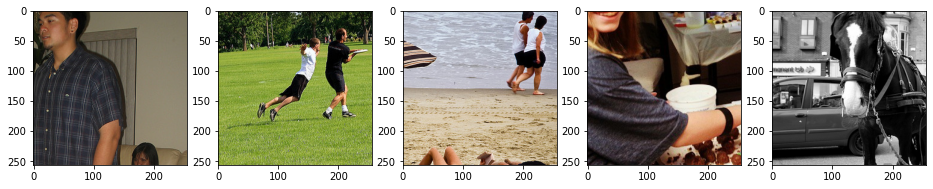

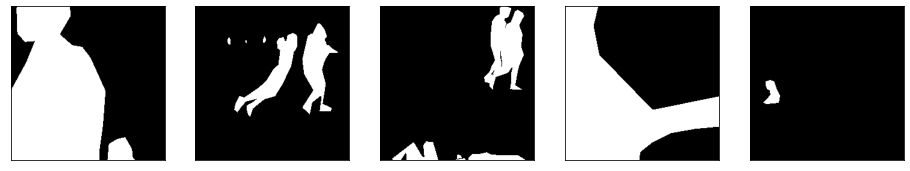

In [10]:
some_samples = [x for x in iter(train_ds.take(5))]

fig = plt.figure(figsize=(16, 16))
for i in range(len(some_samples)):
    ax1 = fig.add_subplot(1, 5, i+1)
    print(some_samples[i][0].shape)
    # print(some_samples[i][1].shape)
    ax1.imshow(some_samples[i][0][0])

fig = plt.figure(figsize=(16, 16))
for i in range(len(some_samples)):
    ax2 = fig.add_subplot(1, 5, i+1)
    ax2.imshow(some_samples[i][1][0].numpy().reshape(256, 256), cmap='gray')
    plt.xticks([]), plt.yticks([])
plt.show()

In [11]:
val_ds

<BatchDataset shapes: ((32, None, None, None), (32, None, None, None)), types: (tf.float32, tf.float32)>

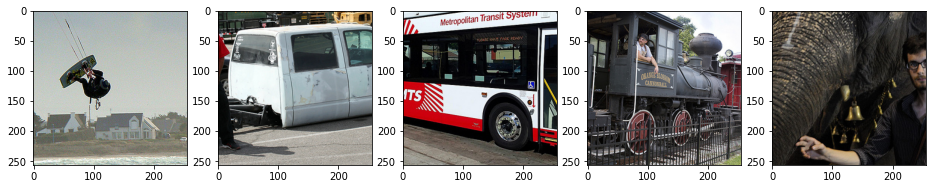

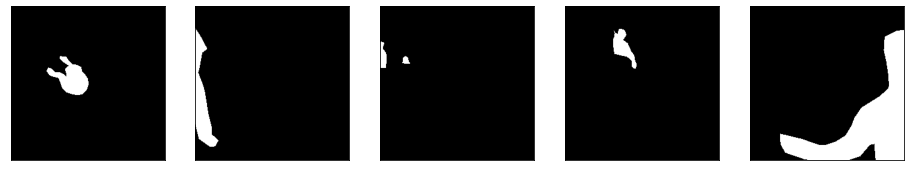

In [12]:
some_samples = [x for x in iter(val_ds.take(5))]

fig = plt.figure(figsize=(16, 16))
for i in range(len(some_samples)):
    ax1 = fig.add_subplot(1, 5, i+1)
    ax1.imshow(some_samples[i][0][0])

fig = plt.figure(figsize=(16, 16))
for i in range(len(some_samples)):
    ax2 = fig.add_subplot(1, 5, i+1)
    ax2.imshow(some_samples[i][1][0].numpy().reshape(256, 256), cmap='gray')
    plt.xticks([]), plt.yticks([])
plt.show()

## Создание модели U-Net

In [0]:
# U-Net
def build_model():
    x = tf.keras.layers.Input((256, 256, 3))
    
    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    out1 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out1)

    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out2 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out2)

    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out3 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out3)

    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out4 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out4)

    out = tf.keras.layers.Conv2D(1024, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(1024, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out4, out], axis=3)

    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out3, out], axis=3)

    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out2, out], axis=3)

    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out1, out], axis=3)

    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(1, (3, 3), padding='same', activation='sigmoid')(out)

    return tf.keras.Model(inputs=x, outputs=out)

In [0]:
model = build_model()

In [15]:
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

## Визуализация U-Net

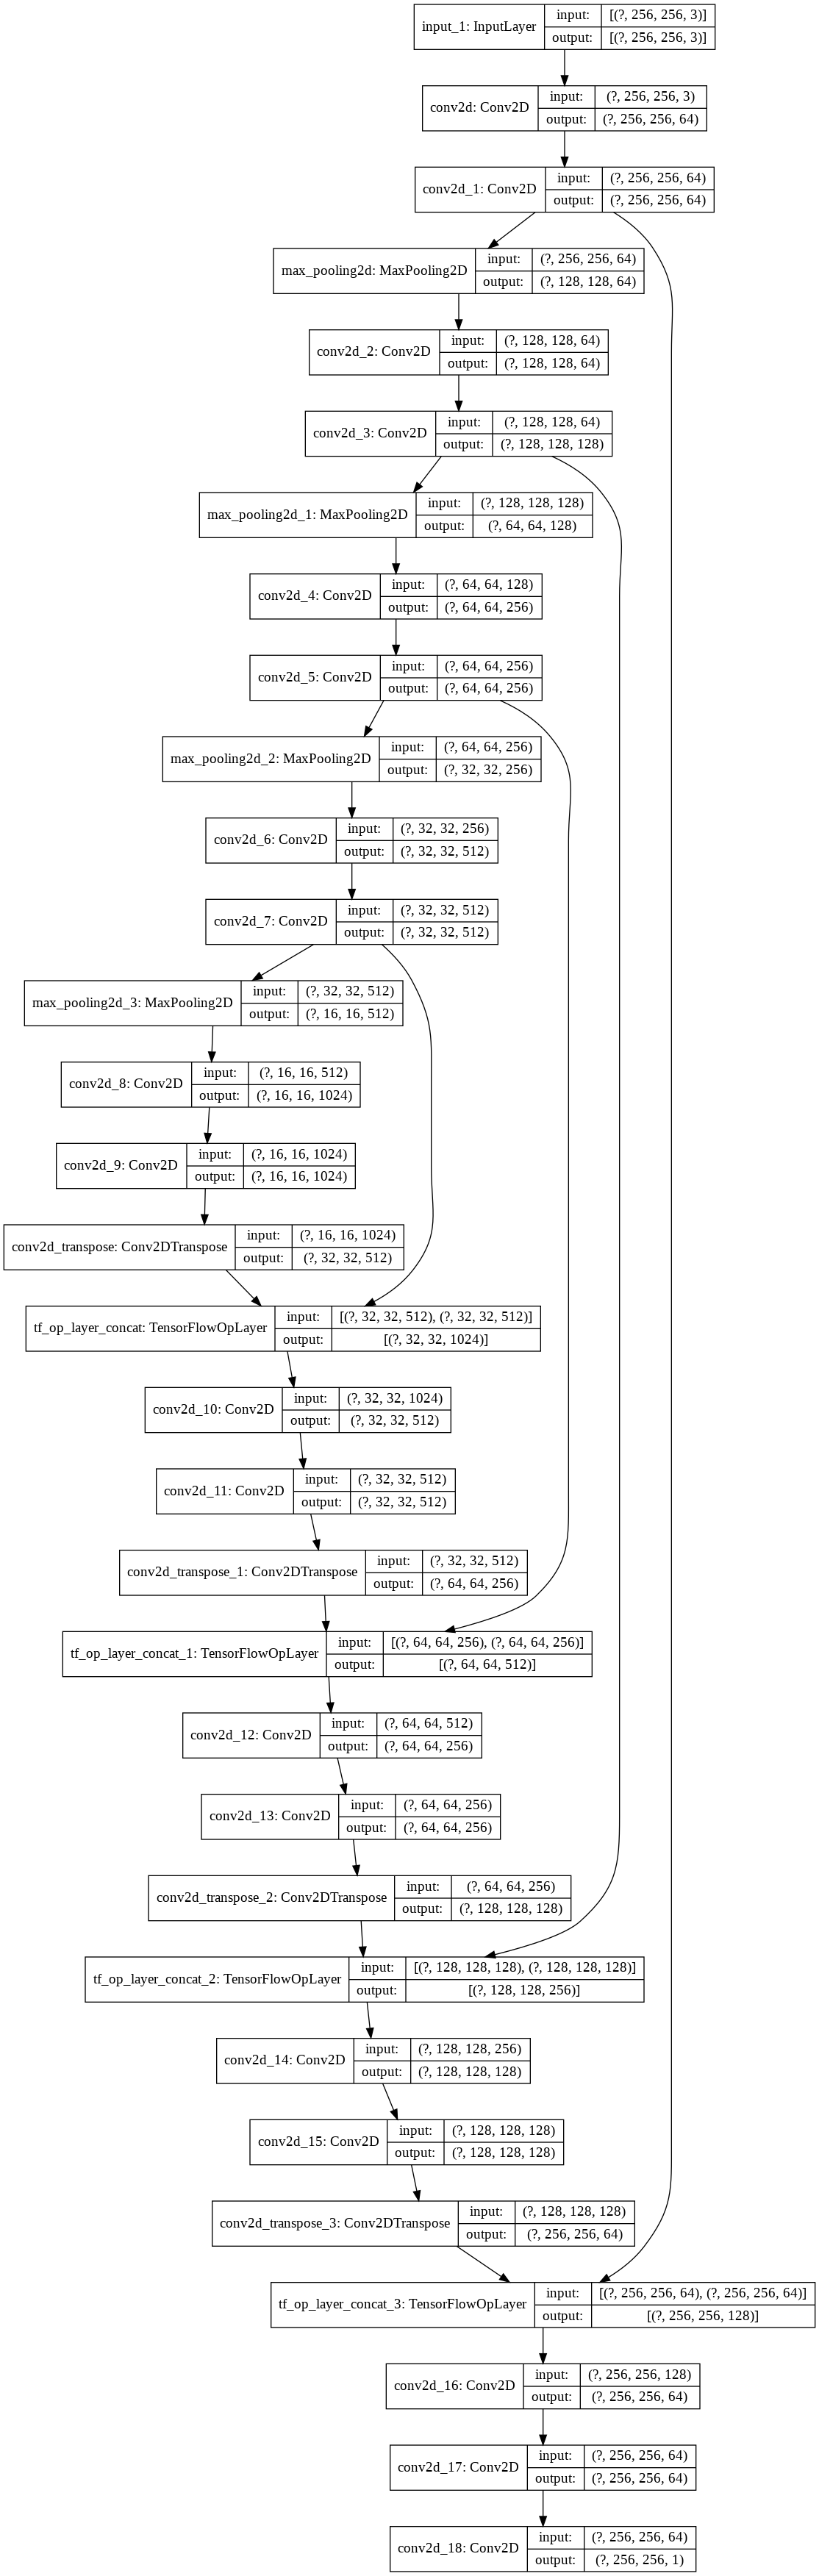

In [16]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [0]:
LEARNING_RATE = 0.0001

optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
# optimizer = tf.keras.optimizers.RMSprop(LEARNING_RATE)

model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy'])

## Обучение модели

Epoch 1/5
10017/10017 [==============================] - 12214s 1s/step - loss: 0.3195
Epoch 2/5
10017/10017 [==============================] - 12012s 1s/step - loss: 0.2187
Epoch 3/5
10017/10017 [==============================] - 12063s 1s/step - loss: 0.1943
Epoch 4/5
10017/10017 [==============================] - 12180s 1s/step - loss: 0.1788
Epoch 5/5
10017/10017 [==============================] - 12092s 1s/step - loss: 0.1686
CPU times: user 10h 32min 31s, sys: 3h 10min 41s, total: 13h 43min 12s
Wall time: 16h 49min 40s


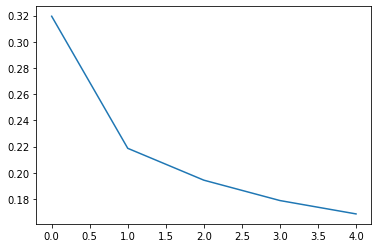

In [18]:
%%time

loss = tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer='adam', loss=loss)

hist = model.fit(train_ds, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS)

plt.plot(hist.history['loss'])

In [19]:
model.evaluate(val_ds)

84/84 [==============================] - 41s 489ms/step - loss: 0.1899


0.18994557857513428

In [0]:
prediction = model.predict(val_ds)

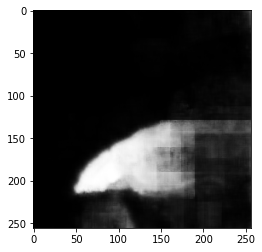

In [21]:
plt.imshow(prediction[357].reshape(256, 256), cmap='gray')
plt.show()

In [0]:
# some_pred = [x for x in iter(prediction[150])]

# len(some_samples)
# # len(some_pred)

In [0]:
model.save_weights('Семантическая_сегментация_COCO_U_NET_onGPU')

In [0]:
import imageio
from skimage.transform import resize

In [0]:
def prepare_image(img):
    img = img.astype(np.float32)/256.
    img = resize(img, (INP_SIZE, INP_SIZE), order=3, mode='reflect', anti_aliasing=True)
    return img.astype(np.float32)


## Наложение карты сегментации на изображение

In [0]:
img = imageio.imread('1234.jpg', pilmode="RGB")
img = prepare_image(img)

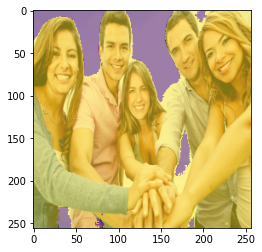

In [30]:
out = model.predict(img[None, ...])
seg_map = (out[0, ..., 0]>0.5).astype(np.float32)
seg_map_clr = plt.get_cmap('viridis')(seg_map)[..., :3]
plt.imshow(img*0.5 + seg_map_clr*0.5)
plt.show()

In [0]:
img = imageio.imread('5678.jpg', pilmode="RGB")
img = prepare_image(img)

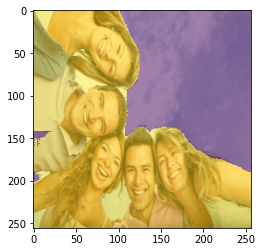

In [41]:
out = model.predict(img[None, ...])
seg_map = (out[0, ..., 0]>0.5).astype(np.float32)
seg_map_clr = plt.get_cmap('viridis')(seg_map)[..., :3]
plt.imshow(img*0.5 + seg_map_clr*0.5)
plt.show()

In [0]:
img = imageio.imread('1542293589.jpg', pilmode="RGB")
img = prepare_image(img)

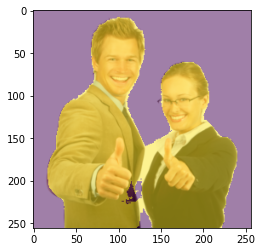

In [43]:
out = model.predict(img[None, ...])
seg_map = (out[0, ..., 0]>0.5).astype(np.float32)
seg_map_clr = plt.get_cmap('viridis')(seg_map)[..., :3]
plt.imshow(img*0.5 + seg_map_clr*0.5)
plt.show()

In [0]:
test_batch = next(iter(val_ds))
prediction = model.predict(test_batch)

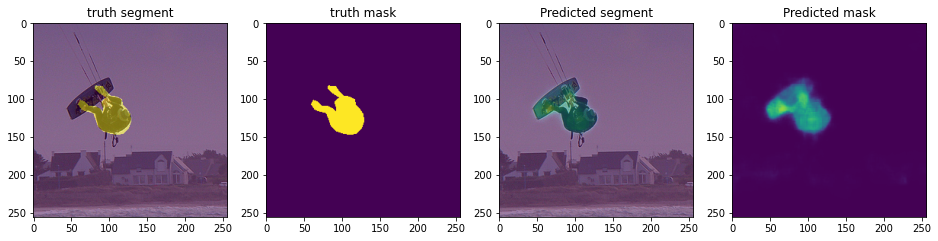

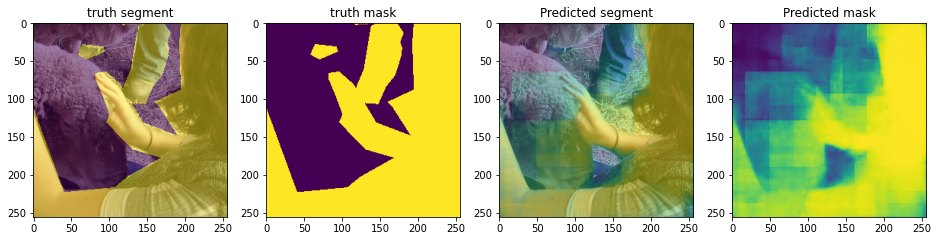

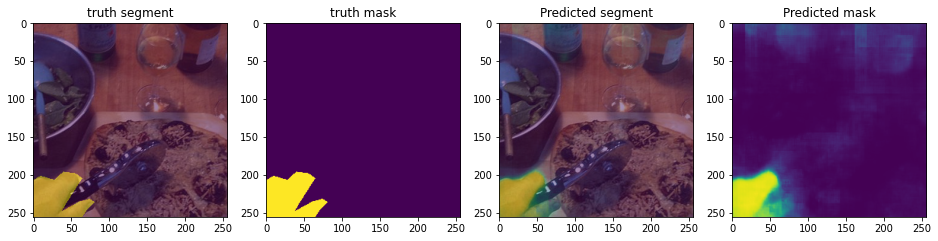

In [37]:
for idx in range(3):
    sample = test_batch[0][idx].numpy()
    
    fig = plt.figure(figsize=(16,6))
    
    plt.subplot(1,4,1)
    plt.title("truth segment")
    actual_seg_map = plt.get_cmap('viridis')(test_batch[1][idx].numpy().reshape(INP_SIZE,INP_SIZE))[..., :3]
    plt.imshow(sample*0.5 + actual_seg_map*0.5)
    plt.subplot(1,4,2)
    plt.title("truth mask")
    actual_seg_map = plt.get_cmap('viridis')(test_batch[1][idx].numpy().reshape(INP_SIZE,INP_SIZE))[..., :3]
    plt.imshow(actual_seg_map)
    plt.subplot(1,4,3)
    plt.title("Predicted segment")
    actual_seg_map = plt.get_cmap('viridis')(prediction[idx].reshape(INP_SIZE,INP_SIZE))[..., :3]
    plt.imshow(sample*0.5 + actual_seg_map*0.5)
    plt.subplot(1,4,4)
    plt.title("Predicted mask")
    actual_seg_map = plt.get_cmap('viridis')(prediction[idx].reshape(INP_SIZE,INP_SIZE))[..., :3]
    plt.imshow(actual_seg_map)
    
    plt.show()